- train on shift=1, ntrials=2, nmaps=4, trlen=?,
- eval on ntrials=2*(nmaps^2) - every possible instruction sequence twice
- assess separation against PI buildup

In [1]:
import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

def mov_avg(arr,wind):
  MA = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    MA[t] = arr[t:t+wind].mean()
  return MA

In [2]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def run_net(net,task,neps,ntrials,trlen,training=True):
  '''
  returns score [neps,ntrials,nmaps+trlen]
  '''
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  exp_len = ntrials*(task.nmaps+trlen)
  score = -np.ones([neps,exp_len])
  for ep in range(neps):
    # forward prop
    iseq,xseq,ytarget = task.gen_ep_data(ntrials,trlen)
    yhat_ulog = net(iseq,xseq)
    # eval
    score_t = (maxsoftmax(yhat_ulog) == ytarget).numpy()
    score[ep] = np.squeeze(score_t)
    if training:
      loss = 0
      for tstep in range(len(iseq)):
        loss += lossop(yhat_ulog[tstep],ytarget[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
  score = score.reshape(neps,ntrials,trlen+task.nmaps)
  return score

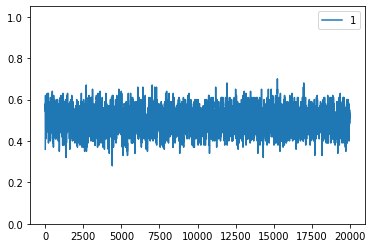

In [48]:
## seed = np.random.randint(99)
# task
nmaps = 2
ntokens_surplus = 0
switchmaps = 1
# net
stsize = 30

neps = 20000
ntrials,trlen=1,10
for em in [1]:
  task = TaskArbitraryMaps(nmaps=nmaps,
                           switchmaps=1,
                           ntokens_surplus=0,
                           seed=seed)
  net = NetAMEM(stsize=stsize,
                emsetting=em,
                wmsetting=1,
                seed=seed)
  trsc = run_net(net,task,neps,ntrials,trlen,training=True)
  tracc = trsc[:,:,nmaps:].mean((1,2))
  plt.plot(mov_avg(tracc,10),label=em)
  
plt.ylim(0,1.05)
plt.legend()

In [29]:
ntr,trl,nm = 2,4,2
task = TaskArbitraryMaps(nmaps=nm,switchmaps=1,ntokens_surplus=0,seed=0)


In [42]:
iseq,xseq,yseq = task.gen_ep_data(ntr,trl)
a = iseq[:,:].reshape(ntr,trl+nm)
b = xseq[:,:,0].reshape(ntr,trl+nm)
c = yseq.reshape(ntr,trl+nm)
for i,j,k  in zip(a.flatten(),b.flatten(),c.flatten()):
  print(i,j,k)


tensor(1) tensor(0.5488) tensor(1)
tensor(2) tensor(0.8918) tensor(2)
tensor(0) tensor(0.5488) tensor(1)
tensor(0) tensor(0.5488) tensor(1)
tensor(0) tensor(0.8918) tensor(2)
tensor(0) tensor(0.8918) tensor(2)
tensor(2) tensor(0.5488) tensor(2)
tensor(1) tensor(0.8918) tensor(1)
tensor(0) tensor(0.8918) tensor(1)
tensor(0) tensor(0.5488) tensor(2)
tensor(0) tensor(0.8918) tensor(1)
tensor(0) tensor(0.8918) tensor(1)


In [33]:
net = NetAMEM(stsize=stsize,emsetting=em,wmsetting=1,seed=seed)

In [43]:
yh = net(iseq,xseq)

0 tensor([1]) tensor(0.5488)
1 tensor([2]) tensor(0.8918)
2 tensor([0]) tensor(0.5488)
3 tensor([0]) tensor(0.5488)
4 tensor([0]) tensor(0.8918)
5 tensor([0]) tensor(0.8918)
6 tensor([2]) tensor(0.5488)
7 tensor([1]) tensor(0.8918)
8 tensor([0]) tensor(0.8918)
9 tensor([0]) tensor(0.5488)
10 tensor([0]) tensor(0.8918)
11 tensor([0]) tensor(0.8918)


In [5]:
'''eval'''
# ntrials_ev,trlen_ev = 20,5
# neps_ev = 200
# evsc = run_net(net,task,neps_ev,ntrials_ev,trlen_ev,training=False)
# block_acc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(block_acc)

# evsc = evsc.reshape(neps_ev,ntrials_ev,trlen_ev+task.nmaps)
# print(evsc.shape)
# evacc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(evacc)
# task.nmaps

['model_data/amtask-sweep1/lstm_20-em_0-nmaps_4-ntrials_2-trlen_20-ntoksurp_0-seed_0-trsc.npy',
 'model_data/amtask-sweep1/lstm_20-em_0-nmaps_4-ntrials_2-trlen_20-ntoksurp_0-seed_1-trsc.npy']

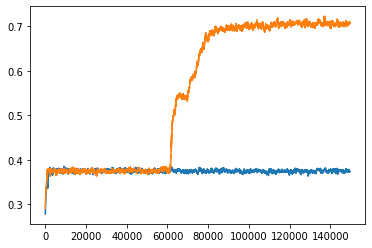

In [58]:
from glob import glob as glob
fdir = 'model_data/amtask-sweep1/'
em,nm,seed = 0,'*','*'
ntr,trl='2','*'

gfpath = 'lstm_20-em_%s-nmaps_%s-ntrials_%s-trlen_%s-ntoksurp_0-seed_%s-trsc.npy'%(em,nm,ntr,trl,seed)
fpathL = glob(fdir+gfpath)
for fpath in fpathL:
  ac = np.load(fpath).mean((1,2))
  plt.plot(mov_avg(ac,500))
fpathL